### A quick demonstration of C-inverse filtering to kappa maps

In [1]:
import numpy as np
import healpy as hp
from matplotlib.pyplot import *
import scipy
# from cmblensplus/wrap/
import basic
import curvedsky as cs
# from cmblensplus/utils/
import plottools as pl
import maptools
# others
import warnings
warnings.filterwarnings("ignore")

In [2]:
# define parameters
ac2rad = np.pi/10800.
deg2rad = np.pi/180.
nside = 512        # CMB map resolution
lmax  = 2*nside     # maximum multipole of alm to be generated
npix = hp.nside2npix(nside)
l = np.linspace(0,lmax,lmax+1)

### Create galaxy survey mask

In [3]:
mask_euclid_base = np.ones(npix)
pixel_theta, pixel_phi = hp.pix2ang(nside, np.arange(npix))
mask_euclid_base[np.abs(pixel_theta-np.pi/2.)<15.*deg2rad] = 0.
mask_euclid_gal = maptools.change_coord(mask_euclid_base, ['E','G'])
mask_euclid_gal[np.abs(pixel_theta-np.pi/2.)<25.*deg2rad] = 0.
mask_euclid = maptools.change_coord(mask_euclid_gal, ['G','C'])

0.40424855550130206


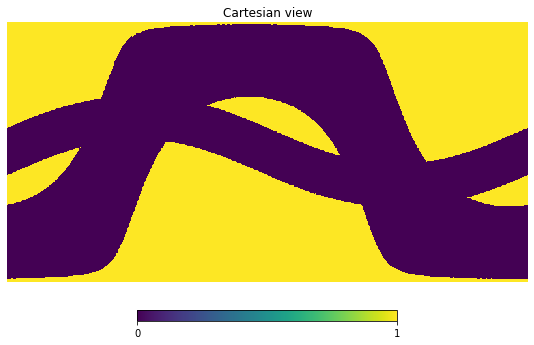

In [4]:
hp.cartview(mask_euclid)
print(np.average(mask_euclid))

In [5]:
W = mask_euclid.copy()
M = W.copy() # binary mask
M[M!=0] = 1.
fsky = np.average(M)

### Prepare signal map

In [6]:
# load cl of mass tracers
cl = {}
fspec = {spec: '../data/spec/cl_'+spec+'.dat' for spec in ['kk','II','gg','kI','kg','Ig']}
ll, cl['kk'] = np.loadtxt(fspec['kk'])
ll, cl['kI'] = np.loadtxt(fspec['kI'])
ll, cl['II'] = np.loadtxt(fspec['II'])

In [7]:
# signal covariance matrix
N = 2
lmin = 1
Cov = np.zeros((N,N,lmax+1))
Cov[0,0,lmin:] = cl['kk'][:lmax+1-lmin]
Cov[1,1,lmin:] = cl['II'][:lmax+1-lmin]
Cov[0,1,lmin:] = Cov[1,0,lmin:] = cl['kI'][:lmax+1-lmin]

In [8]:
# Gaussian alms are generated here
alm = {}
alm['k'], alm['I'] = cs.utils.gaussalm(Cov)

In [9]:
cl0 = cs.utils.alm2cl(lmax,alm['k'])
cl1 = cs.utils.alm2cl(lmax,alm['I'])
clx = cs.utils.alm2cl(lmax,alm['k'],alm['I'])

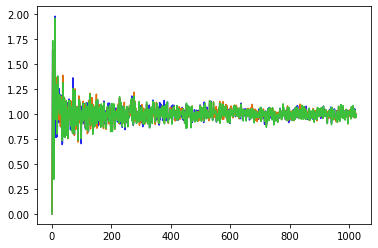

In [10]:
plot(cl0/cl['kk'][:lmax+1])
plot(cl1/cl['II'][:lmax+1])
plot(clx/cl['kI'][:lmax+1])

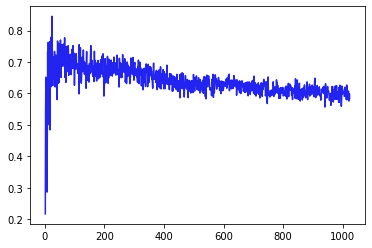

In [11]:
plot(clx**2/cl0/cl1)

### Prepare noise map

In [12]:
nl = {}
ngal = 20. # galaxies per arcmin
nl['k'] = np.ones(len(cl['kk']))*1e-7
nl['I'] = np.ones(len(cl['II']))*1e-2#ac2rad**2/ngal
Ncov = np.zeros((N,N,lmax+1))
Ncov[0,0,:] = nl['k'][:lmax+1]
Ncov[1,1,:] = nl['I'][:lmax+1]

In [13]:
# Gaussian alms are generated here
nlm = {}
nlm['k'], nlm['I'] = cs.utils.gaussalm(Ncov)

In [14]:
# fullsky mass-tracer maps
omap = {}
omap['k'] = cs.utils.hp_alm2map(nside,lmax,lmax,alm['k']+nlm['k'])
omap['I'] = cs.utils.hp_alm2map(nside,lmax,lmax,alm['I']+nlm['I'])

### Wiener filtering (test with the trivial case)

In [15]:
# square root of covariance
clh = np.array( [ scipy.linalg.sqrtm(Cov[:,:,l]) for l in range(0,lmax+1) ] ).T

In [16]:
# inverse noise covariance in fullsky
invnk = np.ones(npix) * 1e7
invnI = np.ones(npix) * 1e2#ac2rad**2/ngal)**(-1)
invN  = np.reshape(np.array((invnk,invnI)),(N,npix))

In [17]:
# kappa maps
kmaps = np.reshape(np.array((omap['k'],omap['I'])),(N,npix))

In [18]:
# Computing filtered-alms
xlm = {}
xlm['k'], xlm['I'] = cs.cninv.cnfilter_kappa(N,nside,lmax,clh,invN,kmaps,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt')

In [19]:
amap, xmap = {}, {}
amap['k'] = cs.utils.hp_alm2map(nside,lmax,lmax,alm['k'])
xmap['k'] = cs.utils.hp_alm2map(nside,lmax,lmax,xlm['k'])
amap['I'] = cs.utils.hp_alm2map(nside,lmax,lmax,alm['I'])
xmap['I'] = cs.utils.hp_alm2map(nside,lmax,lmax,xlm['I'])

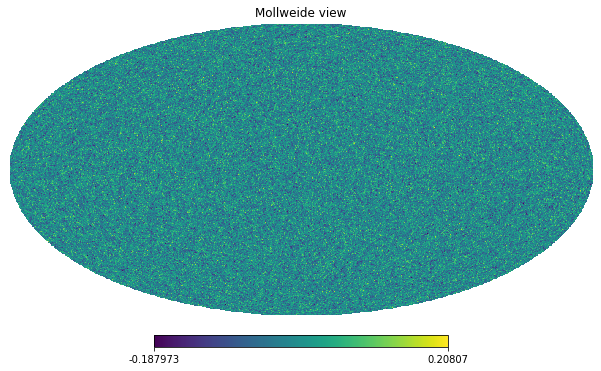

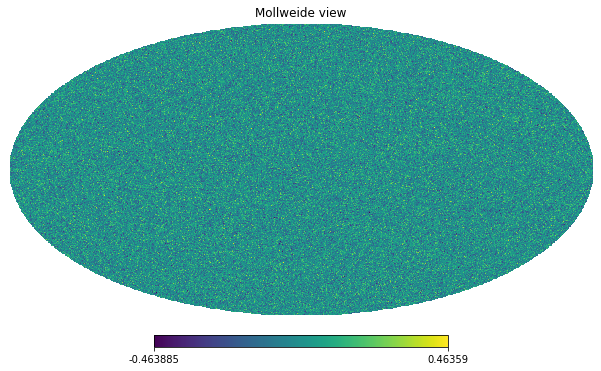

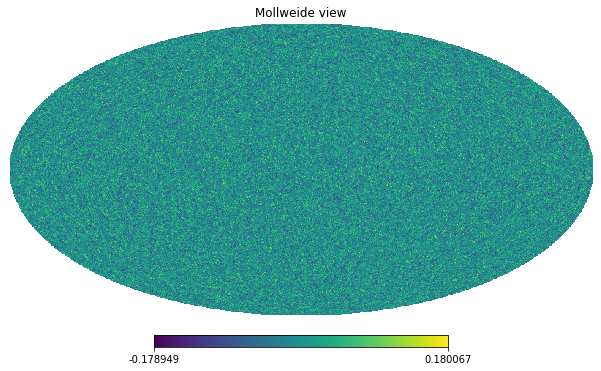

In [20]:
hp.mollview(amap['k'])
hp.mollview(omap['k'])
hp.mollview(xmap['k'])

In [21]:
wcl = np.array( [ np.matmul( Cov[:,:,l], np.matmul( np.linalg.inv(Cov[:,:,l]+Ncov[:,:,l]), Cov[:,:,l] ) ) for l in range(0,lmax+1) ] ).T

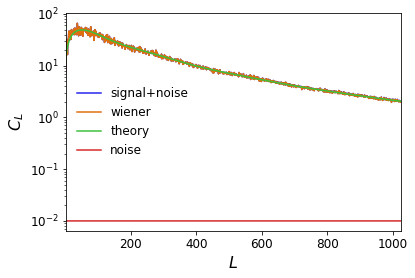

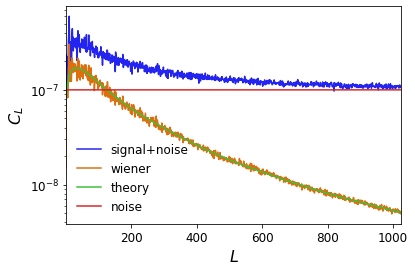

<Figure size 432x288 with 0 Axes>

In [22]:
for (m, mi) in [('I',1),('k',0)]:
    pl.plot_1dstyle(ylog=True,xmin=2,xmax=lmax)
    cl0 = cs.utils.alm2cl(lmax,alm[m]+nlm[m])
    cl1 = cs.utils.alm2cl(lmax,xlm[m])
    plot(l,cl0,label='signal+noise')
    plot(l,cl1,label='wiener')
    plot(wcl[mi,mi,:],label='theory')
    plot(nl[m],label='noise')
    legend()
    show()
    clf()

### Wiener filtering

In [23]:
# alms from masked T/Q/U
olm = {}
olm['k'] = cs.utils.hp_map2alm(nside,lmax,lmax,omap['k']*W)
olm['I'] = cs.utils.hp_map2alm(nside,lmax,lmax,omap['I']*W)

In [24]:
# inverse noise covariance in fullsky
invnk = W * 1e7
invnI = W * 1e2#ac2rad**2/ngal)**(-1)
invN  = np.reshape(np.array((invnk,invnI)),(N,npix))

In [25]:
# mass-tracer maps
kmaps = np.reshape(np.array((omap['k']*M,omap['I']*M)),(N,npix))

In [26]:
# Computing filtered-alms
wlm = {}
wlm['k'], wlm['I'] = cs.cninv.cnfilter_kappa(N,nside,lmax,clh,invN,kmaps,chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt')

In [27]:
wmap = {}
wmap['k'] = cs.utils.hp_alm2map(nside,lmax,lmax,wlm['k'])
wmap['I'] = cs.utils.hp_alm2map(nside,lmax,lmax,wlm['I'])

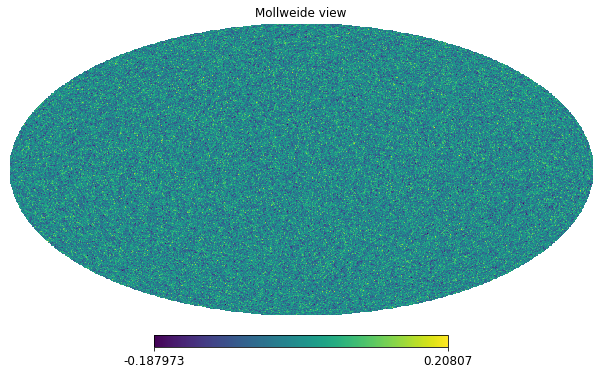

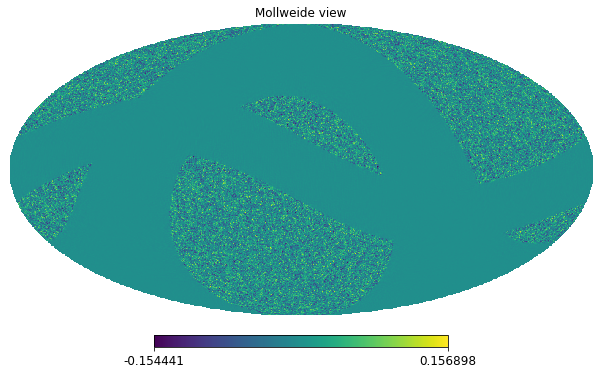

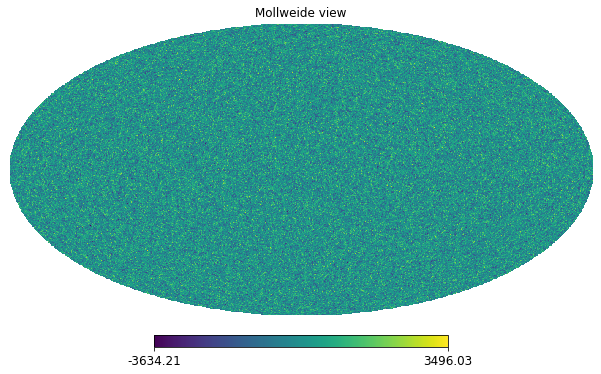

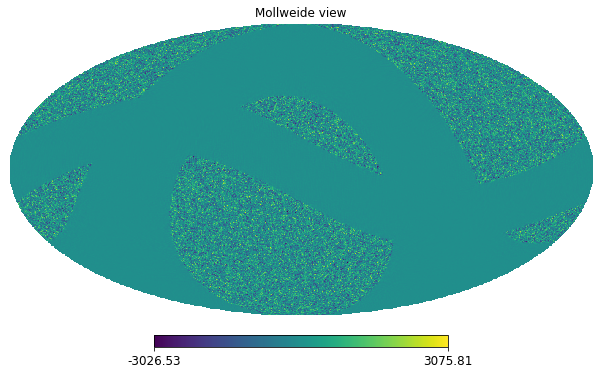

In [28]:
hp.mollview(amap['k'])
hp.mollview(wmap['k'])
hp.mollview(amap['I'])
hp.mollview(wmap['I'])

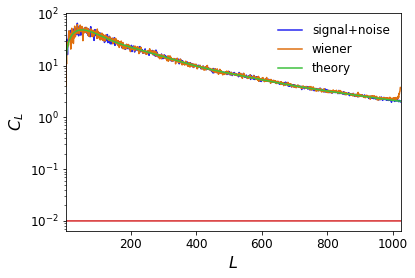

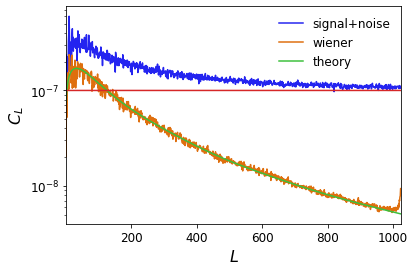

<Figure size 432x288 with 0 Axes>

In [29]:
for (m, mi) in [('I',1),('k',0)]:
    pl.plot_1dstyle(ylog=True,xmin=2,xmax=lmax)
    cl0 = cs.utils.alm2cl(lmax,alm[m]+nlm[m])
    cl1 = cs.utils.alm2cl(lmax,wlm[m])/fsky
    plot(l,cl0,label='signal+noise')
    plot(l,cl1,label='wiener')
    plot(wcl[mi,mi,:],label='theory')
    plot(nl[m])
    legend()
    show()
    clf()

### Optimally coadded kappa map

In [30]:
# square root of covariance
iclh = clh.copy()
iclh[:,:,lmin:] = np.array( [ np.linalg.inv(clh[:,:,l]) for l in range(lmin,lmax+1) ] ).T

In [31]:
# Computing filtered-alms
ilm = {}
ilm['k'], ilm['I'] = cs.cninv.cnfilter_kappa(N,nside,lmax,clh,invN,kmaps,chn=1,itns=[1000],eps=[1e-5],ro=10,iclh=iclh,stat='status.txt')

In [39]:
# Computing filtered-alms
slm = {}
slm['k'] = cs.cninv.cnfilter_kappa(1,nside,lmax,clh[:1,:1,:],invN[:1,:],kmaps[:1,:],chn=1,itns=[1000],eps=[1e-5],ro=10,stat='status.txt')

In [32]:
clm = np.array( [ Cov[0,0,l]*ilm['k'][l,:] + Cov[0,1,l]*ilm['I'][l,:] for l in range(lmax+1) ] )

In [33]:
cmap = cs.utils.hp_alm2map(nside,lmax,lmax,clm)

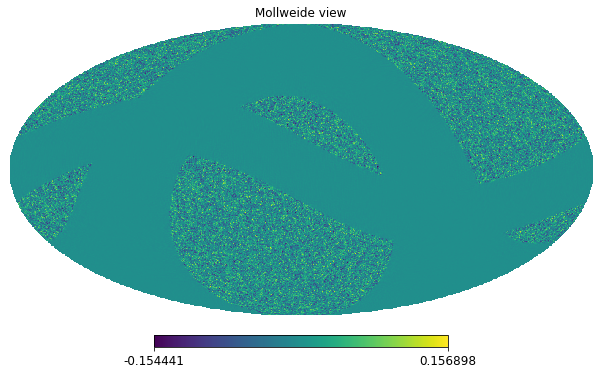

In [34]:
hp.mollview(cmap)

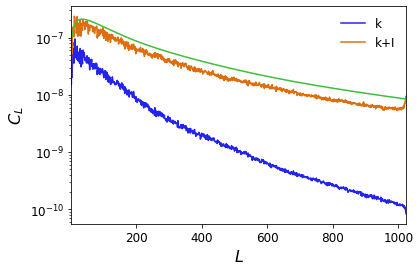

<Figure size 432x288 with 0 Axes>

In [42]:
pl.plot_1dstyle(ylog=True,xmin=2,xmax=lmax)
cl0 = cs.utils.alm2cl(lmax,slm['k'])/fsky
cl1 = cs.utils.alm2cl(lmax,clm)/fsky
plot(l,cl0,label='k')
plot(l,cl1,label='k+I')
plot(ll,cl['kk'])
legend()
show()
clf()